In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../code')

from utils import *
from rnnmodel import *
from tapdynamics import *

In [2]:
"""
Parameters and settings used to generate TAP dynamics
"""

noise_seed = np.random.randint(10000)
print('noise_seed =',noise_seed)
np.random.seed(seed=noise_seed)

Ns = 5     # No. of variables
Nr = 1*Ns  # No. of neurons
Ny = Ns+1  # No. of input variables

# Noise covariances 
Q_process = 0*np.eye(Ns) # process noise
Q_obs = 0*np.eye(Nr)        # use zero noise in train inputs to RNN

# Input setting
gain_y = 25/np.sqrt(Ns) # gain for inputs y

# Filter used for smoothing the input signals
smoothing_filter = signal.hamming(5,sym=True) 
smoothing_filter = smoothing_filter/sum(smoothing_filter)

# TAP model parameters

lam = np.array([0.25])  # low pass filtering constant for the TAP dynamics

nltype = 'sigmoid' # external nonlinearity in TAP dynamics

G = np.array([0,2,0,0,0,0,0,0,0,0,4,-4,0,-8,8,0,0,0]) # message passing parameters of the TAP equation

self_coupling_on = 1 # self coupling in J ON
sparsity_J = 0.3     # sparsity in J 
Jtype = 'nonferr'
J = 3*Create_J(Ns, sparsity_J, Jtype, self_coupling_on) # Coupling matrix  

U = 2*np.random.rand(Nr,Ns) # embedding matrix
# U = np.eye(Nr)

V = np.linalg.svd(np.random.randn(Ns,Ny), full_matrices=False)[2] # input embedding matrix

# concatenate the parameters
theta = np.concatenate([lam, G, JMatToVec(J), U.flatten('F'), V.flatten('F') ])


noise_seed = 6625


In [3]:
"""
Generate training and validation data
"""

B_train, B_val = 1000, 10 # No. of batches
T_train, T_val = 80, 80 # No. of time steps 
T_clip  = 20 # No. of time steps to clip

T_const_train = np.random.randint(low=2,high=20,size=(B_train))
T_const_val = np.random.randint(low=2,high=20,size=(B_val))

y_train = np.zeros([Ny, T_train + T_clip, B_train])
y_val   = np.zeros([Ny, T_val + T_clip, B_val])

# Initial values of latent dynamics
x0_train = np.random.rand(Ns,B_train)
x0_val   = np.random.rand(Ns,B_val)

# Initialize arrays to save dynamics
x_train = np.zeros([Ns, T_train + T_clip + 1, B_train])
r_train = np.zeros([Nr, T_train + T_clip , B_train])

x_val   = np.zeros([Ns, T_val + T_clip + 1, B_val])
r_val   = np.zeros([Nr, T_val + T_clip, B_val])

for bi in range(B_train):
    y_train[:,:,bi] = signal.filtfilt( smoothing_filter, 1, generateBroadH(Ny, T_train + T_clip, T_const_train[bi], gain_y) )
    x_train[:,:,bi], r_train[:,:,bi] = runTAP(x0_train[:,bi], y_train[:,:,bi], Q_process, Q_obs, theta, nltype)

for bi in range(B_val):
    y_val[:,:,bi] = signal.filtfilt( smoothing_filter, 1, generateBroadH(Ny, T_val + T_clip, T_const_val[bi], gain_y) )
    x_val[:,:,bi], r_val[:,:,bi] = runTAP(x0_val[:,bi], y_val[:,:,bi], Q_process, Q_obs, theta, nltype)


In [4]:
"""
Convert ground truth dynamics data to torch tensors
"""    

y_train = torch.tensor(y_train.transpose(2,1,0), dtype=torch.float32) # input signal
r_train = torch.tensor(r_train.transpose(2,1,0), dtype=torch.float32) # target neural activity

y_val = torch.tensor(y_val.transpose(2,1,0), dtype=torch.float32) # input signal
r_val = torch.tensor(r_val.transpose(2,1,0), dtype=torch.float32) # target neural activity


print('No. of batches x T x No. of neurons')
print('Training data:', r_train.shape, 'Validation data:', r_val.shape)

No. of batches x T x No. of neurons
Training data: torch.Size([1000, 100, 5]) Validation data: torch.Size([10, 100, 5])


In [5]:
"""
Create RNN module
"""

N_input, N_hidden, N_output = Ny, 75, Nr

use_cuda = True

tapbrain = RNN(N_input, N_hidden, N_output, use_cuda)

loss_fn = nn.MSELoss()

optimizer = optim.Adam(tapbrain.parameters(),lr=8e-5, betas=(0.9, 0.999))

In [6]:
if use_cuda and torch.cuda.is_available():
    tapbrain.cuda()
    y_train = y_train.cuda()
    r_train = r_train.cuda()
    y_val = y_val.cuda()
    r_val = r_val.cuda()
    

In [7]:
"""
Train the RNN
"""

t_st = time.time()
NEpochs = 1000

train_loss, val_loss = np.zeros([NEpochs]), np.zeros([NEpochs])

  
for epoch in range(NEpochs):
    
    optimizer.zero_grad() # zero-gradients at the start of each epoch
    
    # training data
    rhat_train = tapbrain(y_train)[0]
    
    mse_train = loss_fn(r_train[:,T_clip:],rhat_train[:,T_clip:])
    
    mse_train.backward()  # do backprop to compute gradients 
    
    optimizer.step() # optimization step
    
    # validation data
    rhat_val = tapbrain(y_val)[0]
    
    mse_val = loss_fn(r_val[:,T_clip:],rhat_val[:,T_clip:])
    
    # record loss
    train_loss[epoch] = mse_train.item()
    val_loss[epoch]   = mse_val.item()
    
    if epoch % 1000 == 999:
        print('[%d] training loss: %.5f' %(epoch + 1, mse_train.item()))

print('Finished training')
t_en = time.time()
print('Time elapsed =', np.round(1000*(t_en - t_st))/1000, 's')


[1000] training loss: 0.26682
Finished training
Time elapsed = 332.551 s


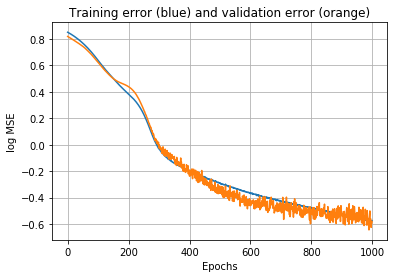

In [8]:
"""
Plot the training and validation MSE as a function of epochs
"""
plt.plot(np.log10(train_loss))
plt.plot(np.log10(val_loss))
plt.title('Training error (blue) and validation error (orange)')
plt.ylabel('log MSE')
plt.xlabel('Epochs')
plt.grid(True)
plt.show()

In [9]:
"""
Convert torch tensors to numpy
"""
y_train    = y_train[:,T_clip:].cpu().data.numpy()
r_train    = r_train[:,T_clip:].cpu().data.numpy()
rhat_train = rhat_train[:,T_clip:].cpu().data.numpy()

y_val    = y_val[:,T_clip:].cpu().data.numpy()
r_val    = r_val[:,T_clip:].cpu().data.numpy()
rhat_val = rhat_val[:,T_clip:].cpu().data.numpy()


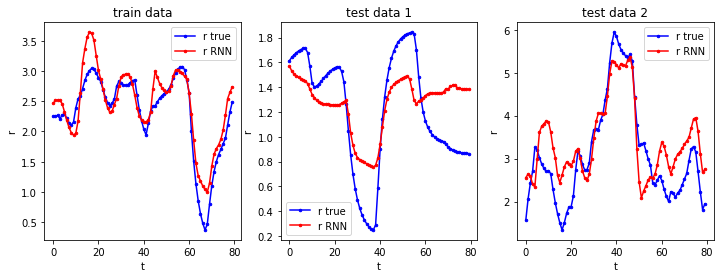

In [10]:
"""
Plot fits to original data: training and val
"""
fig, ax = plt.subplots(1,3,figsize=(12,4))

ax[0].plot(r_train[1,:,0],'b.-',markersize=5)
ax[0].plot(rhat_train[1,:,0],'r.-',markersize=5)
ax[0].set(xlabel='t', ylabel='r', title ='train data')
ax[0].legend(['r true', 'r RNN'])
#ax[0].axis([0,100,0,5])

ax[1].plot(r_val[2,:,0],'b.-',markersize=5)
ax[1].plot(rhat_val[2,:,0],'r.-',markersize=5)
ax[1].set(xlabel='t', ylabel='r', title ='test data 1')
ax[1].legend(['r true', 'r RNN'])
#ax[1].axis([0,100,0,5])

ax[2].plot(r_val[5,:,1],'b.-',markersize=5)
ax[2].plot(rhat_val[5,:,1],'r.-',markersize=5)
ax[2].set(xlabel='t', ylabel='r', title ='test data 2')
ax[2].legend(['r true', 'r RNN'])
#ax[2].axis([0,100,0,5])

plt.show()


In [11]:
"""
Generate test data
"""

B_test = 5  # No. of batches
T_test = 1000 # No. of time steps 

# change test data parameters
T_const_test = np.random.randint(2,20,size=(B_test))


y_test   = np.zeros([Ny, T_test + T_clip, B_test])

# Initial values of latent dynamics
x0_test   = np.random.rand(Ns,B_test)

# Initialize arrays to save dynamics
x_test   = np.zeros([Ns, T_test + T_clip + 1, B_test])
r_test   = np.zeros([Nr, T_test + T_clip, B_test])

for bi in range(B_test):
    y_test[:,:,bi] = signal.filtfilt( smoothing_filter, 1, generateBroadH(Ny, T_test + T_clip, T_const_test[bi], gain_y) )
    x_test[:,:,bi], r_test[:,:,bi] = runTAP(x0_test[:,bi], y_test[:,:,bi], Q_process, Q_obs, theta, nltype)
    
y_test = torch.tensor(y_test.transpose(2,1,0), dtype=torch.float32) # input signal
r_test = torch.tensor(r_test.transpose(2,1,0), dtype=torch.float32) # target neural activity


print('No. of batches x T x No. of neurons')
print('Test data:', r_test.shape)

No. of batches x T x No. of neurons
Test data: torch.Size([5, 1020, 5])


In [12]:
"""
Run model on test data
"""
if torch.cuda.is_available():
    y_test = y_test.cuda()
rhat_test = tapbrain(y_test)[0]

y_test    = y_test[:,T_clip:].cpu().data.numpy()
r_test    = r_test[:,T_clip:].cpu().data.numpy()
rhat_test = rhat_test[:,T_clip:].cpu().data.numpy()

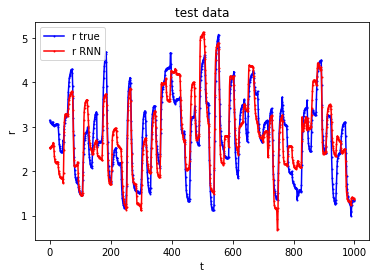

In [13]:
"""
Test data
"""
plt.plot(r_test[0,:,0],'b.-',markersize=2)
plt.plot(rhat_test[0,:,0],'r.-',markersize=2)
plt.xlabel('t')
plt.ylabel('r')
plt.title('test data')
plt.legend(['r true', 'r RNN'])

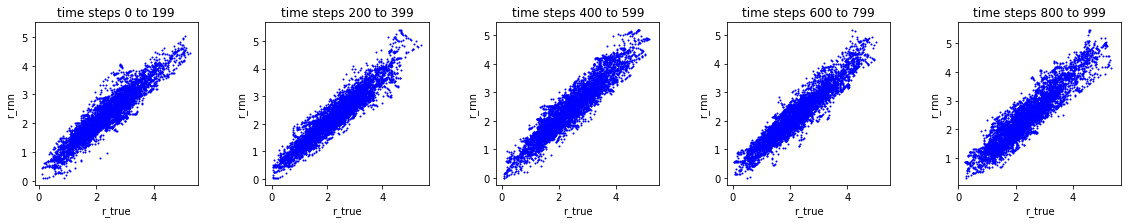

In [14]:
"""
Scatter plot for test data for every C time steps
"""
C = 200
N = T_test//C


fig, ax = plt.subplots(1,N,figsize=(4*N,3))

for ni in range(N):
    ax[ni].plot(r_test[:,ni*C:(ni+1)*C].flatten(), rhat_test[:,ni*C:(ni+1)*C].flatten(),'b.',markersize=2)
    ax[ni].axis('square')
    ax[ni].set(xlabel='r_true', ylabel='r_rnn', title = 'time steps ' +str(ni*C)+ ' to ' + str(ni*C + C-1))

In [15]:
"""
convert model to cpu and save it
"""
tapbrain.cpu()

RNN(
  (input_to_hidden): Linear(in_features=81, out_features=75, bias=True)
  (hidden_to_output): Linear(in_features=80, out_features=5, bias=True)
  (activation_function): ReLU()
)

In [16]:
"""
Save trained brain and required variables
"""

brain_name = '../data/brains/' + 'Ns_'+ str(Ns) + '_noiseseed_' + str(noise_seed)
torch.save(tapbrain,brain_name + '.pt')
params = {'Ny':Ny, 'Nr': Nr, 'Ns': Ns, 'Q_process': Q_process, 'Q_obs': Q_obs, 'nltype': nltype, 'Jtype':Jtype, 'sparsity_J': sparsity_J, 'self_coupling_on': self_coupling_on, 'gain_y':gain_y, 'smoothing_filter': smoothing_filter}

with open(brain_name + '_params.pkl', 'wb') as f:  
    pickle.dump([theta, params], f)
f.close()